In [1]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from tqdm import tqdm

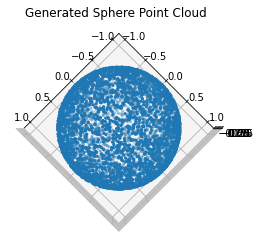

In [2]:
def generate_sphere_point_cloud(num_points, radius=1):
    phi = torch.rand(num_points) * 2 * torch.pi
    theta = torch.acos(2 * torch.rand(num_points) - 1)

    x = radius * torch.sin(theta) * torch.cos(phi)
    y = radius * torch.sin(theta) * torch.sin(phi)
    z = radius * torch.cos(theta)

    return torch.stack((x, y, z), dim=1)

# Parameters
n_samples = 5000

# Generate a sphere point cloud with 5000 points and radius 1
sphere_cloud = generate_sphere_point_cloud(n_samples, radius=1)


# Visualize the point cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sphere_cloud[:, 0], sphere_cloud[:, 1], sphere_cloud[:, 2], s=5)
ax.set_aspect('equal')
ax.set_title("Generated Sphere Point Cloud")
ax.view_init(90, 40)
plt.show()

In [27]:
def exp_map_manifold(point_cloud, p, v, k = 500):
    #p: (n-array) the initial point p in the point cloud   v: (n-array) the dirctional vector 
    #k: number of neighbors used for finding best transported point
    
    nbrs = NearestNeighbors(n_neighbors=k + 1, algorithm='ball_tree').fit(point_cloud)  
    dist, p_new_index = nbrs.kneighbors(p.reshape(1, -1) + v)
    q = point_cloud[p_new_index[:, 0]]
    
    return q

def list_vector_of_index(set_vectors, list_indices):
    
    list_result_vectors = [np.array([set_vectors[i] for i in list_indices[j]]) for j in range(len(list_indices))]
    
    return list_result_vectors

In [34]:
def parallel_transport_manifold(point_cloud, v, p, q, stalk_dim = 2, k = 500, epsilon_PCA = 0.2):
    
        
    nbrs = NearestNeighbors(n_neighbors=k + 1, algorithm='ball_tree').fit(point_cloud) 
   #compute basis at p
    dist_p, p_nbrs_index = nbrs.kneighbors(p.reshape(1, -1))
    x_N_p = point_cloud[p_nbrs_index][1:]
    X_i_p = x_N_p - p
    D_i_p = np.diag(np.sqrt(np.exp( - 5 * np.array(dist_p[0][1:]) ** 2 / epsilon_PCA)))
    U_p, S_p, VT_p = np.linalg.svd(X_i_p.T @ D_i_p, full_matrices = False)
    O_p = U_p[:, :stalk_dim]
    
    #compute basis at q
    dist_q, q_nbrs_index = nbrs.kneighbors(np.expand_dims(q, axis = 0))
    x_N_q = point_cloud[q_nbrs_index][1:]
    X_i_q = x_N_q - q
    D_i_q = np.diag(np.sqrt(np.exp( - 5 * np.array(dist_q[0][1:]) ** 2 / epsilon_PCA)))
    U_q, S_q, VT_q = np.linalg.svd(X_i_q.T @ D_i_q, full_matrices = False)
    O_q = U_q[:, :stalk_dim]
    
    #compute parallel transport
    U, S, VT = np.linalg.svd(O_p.T @ O_q, full_matrices = False)
    O_pq = U @ VT #this is a matrix of 2 x 2
    
    #transport the vector v to at point q
    v_0 = np.array([np.dot(v, O_p.T[0]), np.dot(v, O_p.T[1])])
    v_q = O_pq @ v_0
    v_q = v_q[0] * O_q.T[0] + v_q[1] * O_q.T[1]  #change it to the vector form of coord (x, y, z)

        
    
    
    return v_q

In [13]:

p = sphere_cloud[0]
q = sphere_cloud[1]
p

tensor([-0.4807,  0.8738, -0.0742])

In [16]:
nbrs = NearestNeighbors(n_neighbors=5 + 1, algorithm='ball_tree').fit(sphere_cloud) 
    #compute basis at p
dist_p, p_nbrs_index = nbrs.kneighbors(p.reshape(1, -1))

In [18]:
c = np.array([[1, 1, 1], [4, 5, 6]])
np.linalg.norm(c, axis = -1)

array([1.73205081, 8.77496439])

In [20]:
class Geonet(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(1,hidden_dim),
                    nn.ReLU(),
                    nn.Linear(hidden_dim,hidden_dim),
                    nn.ReLU(),
                    nn.Linear(hidden_dim,hidden_dim),
                    nn.ReLU(),
                    nn.Linear(hidden_dim, input_dim))
    
    def forward(self, t):
        """
        x0 : N x d
        x1 : N x d
        t : T

        output : T x N x d
        """
       
        #outs =  self.mod(t) * enveloppe + avg
        #next_point = exp_map_manifold(self.point_cloud, self.net(t)[:imput_dim], self.net(t)[imput_dim: 2 * input_dim], k = self.k)
        #next_vector = parallel_transport_manifold(self.point_cloud, self.net(t)[imput_dim: 2 * input_dim], self.net(t)[:imput_dim], next_point, stalk_dim = self.stalk_dim, k = self.k, epsilon_PCA = 0.2)
        return self.net(t)
        #return torch.cat([next_point, next_vector.reshape(1, -1)])

In [93]:
dim = 3
hidden_dim = 16
x0 = sphere_cloud[2].detach().numpy()
x1 = sphere_cloud[1].detach().numpy()
point_cloud = sphere_cloud
t = torch.linspace(0,1,100)[:,None]

In [86]:
curve = Geonet(dim, hidden_dim)

optimizer = torch.optim.Adam(curve.parameters(), lr=0.01)

In [102]:
batch_size = 256
losses = []
K = 200
N = 100
t = torch.linspace(0,1,N)[:,None]
v_start = x1- x0
P = 0.2

points_all = np.zeros((100, N, dim))
for k in tqdm(range(10)):

    optimizer.zero_grad()
    
    #t = torch.rand((batch_size,1))
    
    inter_points = np.zeros((N, dim))
    parall_vs = np.zeros((N, dim))
    inter_points[0] = x0
    parall_vs[0] = 1/N * v_start
    
    out = curve(t).detach().numpy()
    norm_v = np.linalg.norm(out, axis = -1)
    v = out/norm_v.reshape(-1, 1) * np.linalg.norm(parall_vs[0])
    
    
    pred_vs = np.zeros((N, dim)) 
    
    pred_ps = np.zeros((N, dim))
    pred_ps[0] = x0
    
    for i in np.arange(1, N):
        # this is transporting x0 to final point
        inter_points[i] = exp_map_manifold(point_cloud, inter_points[i - 1], parall_vs[i - 1], k = K) 
        # the following is computing the transported vector step by step
        parall_vs[i] = parallel_transport_manifold(point_cloud, parall_vs[i - 1], inter_points[i - 1], 
                                                  inter_points[i], stalk_dim = dim -1, k = K, epsilon_PCA = P)
        #the following is predicted points from neural network
        pred_vs[i] = parallel_transport_manifold(point_cloud, v[i - 1], inter_points[i - 1], 
                                                 inter_points[i], stalk_dim = dim -1, k = K, epsilon_PCA = P)
        #the follwing is predicted vectors
        pred_ps[i] = exp_map_manifold(point_cloud, inter_points[i - 1], v[i - 1], k = K)
        
    err_vec = x1 - pred_ps[-1]
    #now parallel transport it back
    for i in np.arange(1, N):
        err_vec = parallel_transport_manifold(point_cloud, err_vec, pred_ps[N - i], 
                                              pred_ps[N -i -1], stalk_dim = dim -1, k = K, epsilon_PCA = P)
        
    #the following is the transporting back the error vector back to x0 
    grad_v = err_vec
    
    err_p_parral = x1 - inter_points[-1] 
    err_p_pred = x1 - pred_ps[-1]
    error_v = pred_vs[1:] - parall_vs[1:]
    #loss1 = sum(np.linalg.norm(error_v, axis = -1))
    #loss2 = np.linalg.norm(err_p_parral)
    #loss3 = np.linalg.norm(err_p_pred)
    loss4 = np.linalg.norm(grad_v)

    #loss = loss1/N + loss2 + loss3
    loss = loss4
    loss = torch.tensor(loss, requires_grad=True)
    loss.backward()
    optimizer.step()
    losses.append(loss.detach().numpy())

100%|██████████| 10/10 [00:13<00:00,  1.36s/it]


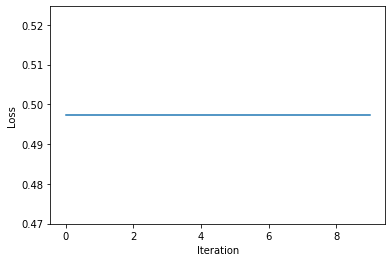

In [103]:
plt.figure()
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

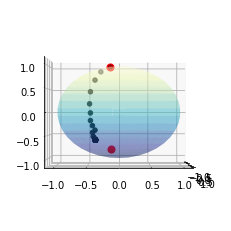

In [104]:
out = curve(t).detach().numpy()

inter_points = np.zeros((N, dim))
inter_points[0] = x0
for i in np.arange(1, N):
    inter_points[i] = exp_map_manifold(point_cloud, inter_points[i - 1], out[i - 1], k = K)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(inter_points[:, 0], inter_points[:, 1], inter_points[:,2], c= 'black')
ax.scatter(x0[0], x0[1], x0[2], s = 50, c = 'r')
ax.scatter(x1[0], x1[1], x1[2], s = 50, c = 'r')

u, v = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
x = np.cos(u) * np.sin(v)
y = np.sin(u) * np.sin(v)
z = np.cos(v)
ax.plot_surface(x, y, z, cmap=plt.cm.YlGnBu_r, alpha=0.3)
ax.view_init(0, 0)
plt.show()